# <font color="red">CSE499A - Assignment 01</font>

## Joy Kumar Ghosh - 2211424642
Section-17

### Install & Import Library

In [1]:
%pip install qiskit
%pip install pylatexenc
%pip install qiskit-aer
%pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.quantum_info import Operator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, pauli_error

from math import sqrt
import random
from collections import Counter
import time

# qiskit ignis is no longer supported, so i copy the function that is needed in a file and fixed an import error
from calibration import complete_meas_cal, CompleteMeasFitter
from calibration import callibrationCircuitSampler, samplerResultListToAerResult, samplerResultToAerResult

In [3]:
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="11318f27c420947d9fcc114bdf0dc0103873ca807db5e77f68463decf6fef341ea99779afdbf5c13cc9d87c68cffb3c8011cb4a1a1165f10d62f87eaee3cee4f",
                                  overwrite=True,
                                  set_as_default=True)

## Question - 01
Build a 1-qubit circuit and initialize its state in superposition without using any gate. Qubits must be in different relative phases.\
Implement proper state vector visualization technique.\
Explain your understanding in detail.

### Construct the Circuit

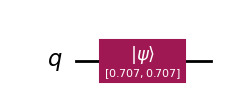

In [4]:
circuit = QuantumCircuit(1)

# probablity of a superposition state
probabilities = (1/sqrt(2), 1/sqrt(2))

# initializing circuit with probablity amplitudes
circuit.initialize(probabilities, 0)

circuit.draw('mpl')

### Run on Simulator for geting the state vector and qsphere

In [5]:
simulator = AerSimulator()
circuit.save_statevector()
job = simulator.run(circuit)
result = job.result()

### Visualize State Vector

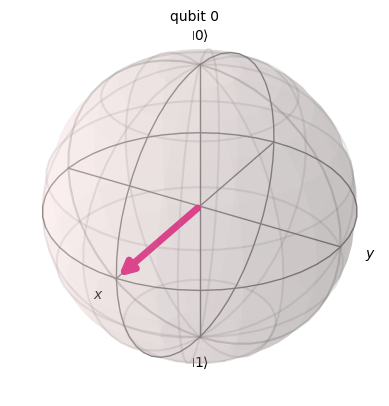

In [6]:
final_state = result.get_statevector()
plot_bloch_multivector(final_state)

=> State is now on the X axis, means it is in superposition state

### Visualize in Quantum Sphere

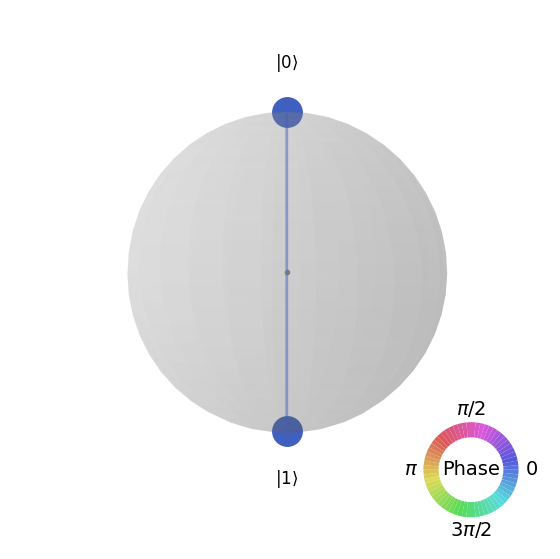

In [7]:
plot_state_qsphere(final_state)

=> Understanding:\
In superposition, state can be in both state |0> or |1> at the same time. When we measure, state collaps and provide us any one outcome. In Superposition, probablities of outcome for 0 and 1 is the same.

## Question - 02
You have to create a circuit with the gates CCX, H, SX (√X gate) in such a way that\
you always have roughly  ¼ probability to get state |1> from the target qubit of CCX.\
Create a new Unitary gate with the above mentioned gates according to your implementation and apply to the circuit.\
Now, alter the circuit with Y basis measurement and explain the differences in outcome briefly.

### Constructing circuit

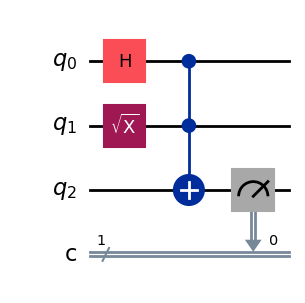

In [8]:
circuit = QuantumCircuit(3, 1)

circuit.h(0)
circuit.sx(1)
circuit.ccx(0, 1, 2)

circuit.measure(2, 0)

circuit.draw('mpl')

### Testing on Simulator, outcome State 1 from the target qubit will be near 25%

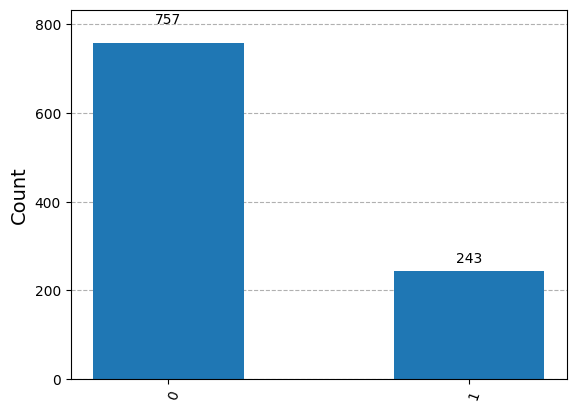

In [9]:
job = AerSimulator().run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> Outcome from the target qubit is nearly 25%, so the circuit construction is complete

### Extracting the gate sequence in as a custom Unitary Gate

In [10]:
circuit = QuantumCircuit(3)

circuit.h(0)
circuit.sx(1)
circuit.ccx(0, 1, 2)

custom_gate = circuit.to_gate(label="CustomUnitary")

### Creating another circuit with the Custom Gate for testing

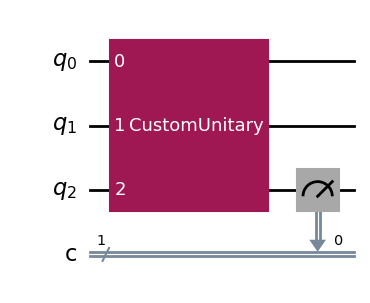

In [11]:
circuit = QuantumCircuit(3, 1)
circuit.append(custom_gate, [0, 1, 2])

circuit.measure(2, 0)

circuit.draw('mpl')

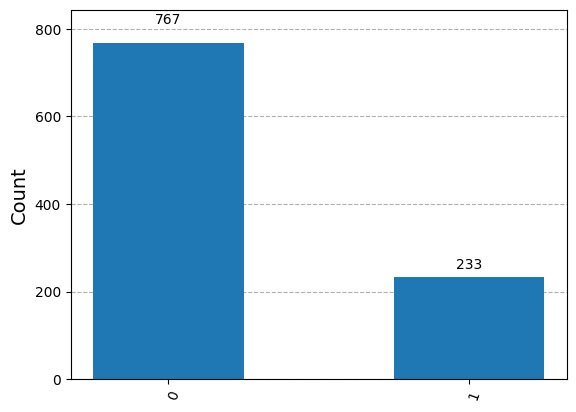

In [12]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> Outcome from the target qubit is nearly 25%, so circuit is working according to the instruction.

### Y - basis Measurement

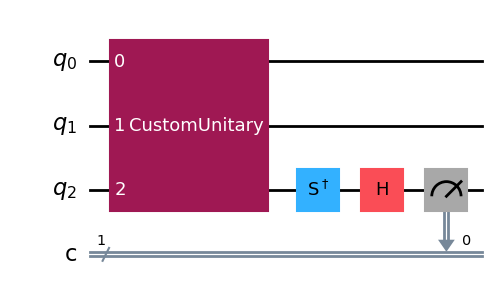

In [13]:
circuit = QuantumCircuit(3, 1)
circuit.append(custom_gate, [0, 1, 2])

# preaparing for y basis measurement
circuit.sdg(2)
circuit.h(2)
circuit.measure(2, 0)

circuit.draw('mpl')

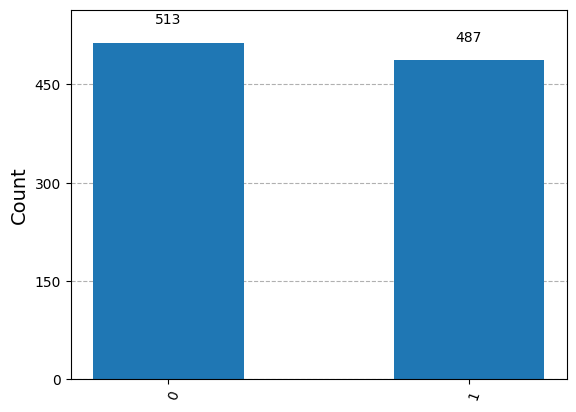

In [14]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> We initialize the circuit on z basis. But here we are measuring the circuit on y basis. According to the Heisenberg Uncertainty Principle, if we initialize the circuit in a basis and measure on the other basis, the outcome will be uncertain.\
Here, we initialize the circuit as the outcome for 1 should be nearly 25% but we get around 50%, because of this uncertainty principle.

## Question - 03
Calculate the unitary for the circuit (both Z and Y basis measurement) created in problem 2.\
Explain the differences in outcome and your understanding briefly.

### Unitary Matrix for Z Basis

In [15]:
circuit = QuantumCircuit(3)

circuit.h(0)
circuit.sx(1)
circuit.ccx(0, 1, 2)

unitary = Operator(circuit).data
print("Unitary matrix for the circuit:")
array_to_latex(unitary)

Unitary matrix for the circuit:


<IPython.core.display.Latex object>

=> here some positions are 0, so there is some state which probabilities will be zero, and we can say that the result will be certain according our circuit design.

### Unitary Matrix for Y Basis

In [16]:
circuit = QuantumCircuit(3)

circuit.h(0)
circuit.sx(1)
circuit.ccx(0, 1, 2)

circuit.sdg([0, 1, 2])
circuit.h([0, 1, 2])

unitary = Operator(circuit).data
print("Unitary matrix for the circuit:")
array_to_latex(unitary)

Unitary matrix for the circuit:


<IPython.core.display.Latex object>

=> here we can see that there is no zero, that means outcome can be anything, and almost equally distributed. So, the outcome will be uncertain.

## Question - 04
Create an entanglement circuit with H, CX gate and apply measurement.\
Run on both a simulator and real quantum device.\
Use proper error mitigation techniques for the real backend (level 1 or level 2).\
Compare the results you obtained by plotting histograms.\
Explain your understanding in detail.

### Entanglement Circuit

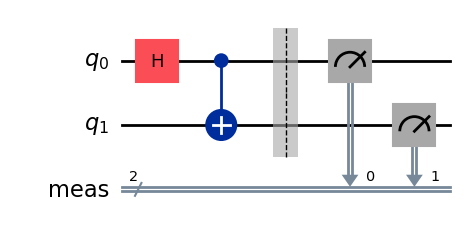

In [17]:
circuit = QuantumCircuit(2)

circuit.h(0)
circuit.cx(0, 1)

circuit.measure_all()

circuit.draw("mpl")

### Run on Simulator

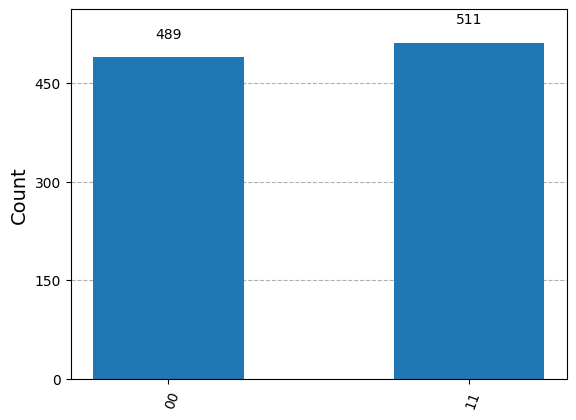

In [18]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> As we construct an Entanglement circuit using 2 qubit, the outcome will be same for both qubit, either 00 or 11.

### Run on Real Devices

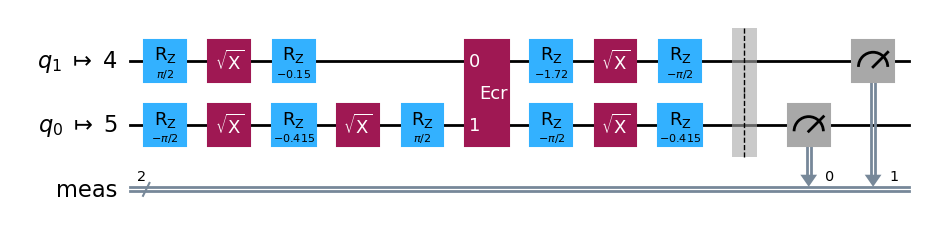

In [19]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pass_manager.run(circuit)
isa_circuit.draw("mpl", idle_wires=False)

In [20]:
# toakes a long time to run so we will retrieve the result later

""" sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)

while True:
    print(f"Job Status: {job.status()}")
    if job.status() == "DONE" or job.status() == "ERROR":
        break
    time.sleep(10)  # Check status every 10 seconds

result = job.result()
result_real = result[0] """

' sampler = Sampler(backend)\njob = sampler.run([isa_circuit], shots=1000)\n\nwhile True:\n    print(f"Job Status: {job.status()}")\n    if job.status() == "DONE" or job.status() == "ERROR":\n        break\n    time.sleep(10)  # Check status every 10 seconds\n\nresult = job.result()\nresult_real = result[0] '

In [21]:
service = QiskitRuntimeService()

job_id = "cwy76tv60bqg008pzdv0"
retrieved_job = service.job(job_id)
retrieved_job.status()

'DONE'

In [22]:
job = retrieved_job
result = job.result()
result_real = result[0]

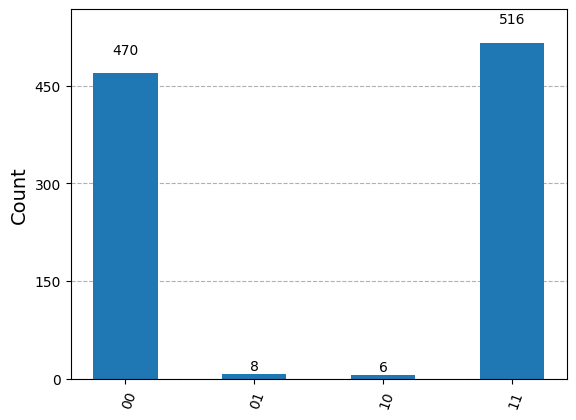

In [23]:
counts_real = result_real.data.meas.get_counts()
plot_histogram(counts_real)

=> as we know real device have some noise and error, thats why we are getting some output like 01 and 10, but the amount is very low. For these error, we need to run our circuit multiple time and consider the output of which sequence is higher than others.

### Error Mitigation - Simulator

#### Entangglement Circuit

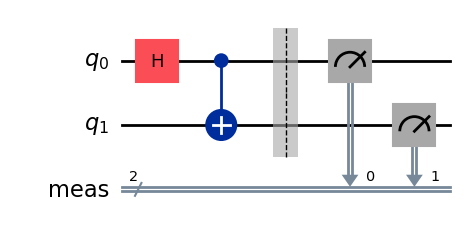

In [24]:
circuit = QuantumCircuit(2)

circuit.h(0)
circuit.cx(0, 1)

circuit.measure_all()

circuit.draw("mpl")

#### Define Noise Model

In [25]:
def get_noise(p):
    error_message = pauli_error([('X', p), ('I', 1-p)])

    noise_model = NoiseModel()

    #apply measurement error to noise model
    noise_model.add_all_qubit_quantum_error(error_message, "measure")

    return noise_model

In [26]:
# 10% chance of happening measurement error
noise_model = get_noise(0.1)

#### Generate Calibration Circuit

In [27]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

#### Run calibration Circuit with Noise

In [28]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(meas_calibs)
job = simulator.run(isa_circuit, shots=1000, noise_model=noise_model)
cal_result = job.result()

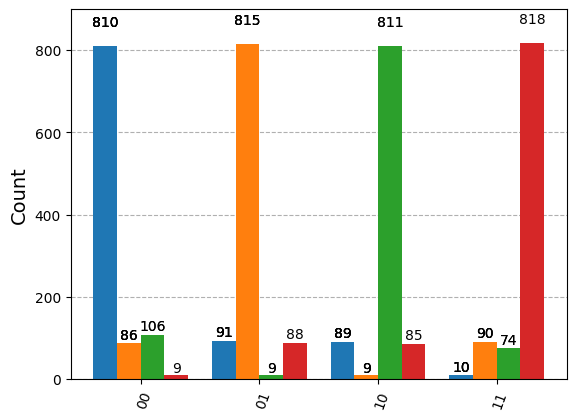

In [29]:
counts = cal_result.get_counts()
plot_histogram(counts)

#### Calibration Matrix with Noise

In [30]:
meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

#### Run the circuit with Noise

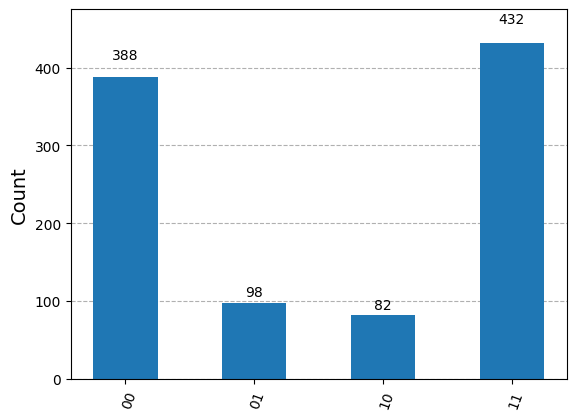

In [31]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000, noise_model=noise_model)
noisy_results = job.result()
noisy_counts = noisy_results.get_counts()
plot_histogram(noisy_counts)

#### Mitigate the Noise

In [32]:
# get the fitter object
meas_fitter = meas_fitter.filter

# results with mitigation
mitigated_results = meas_fitter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()

#### Comparison

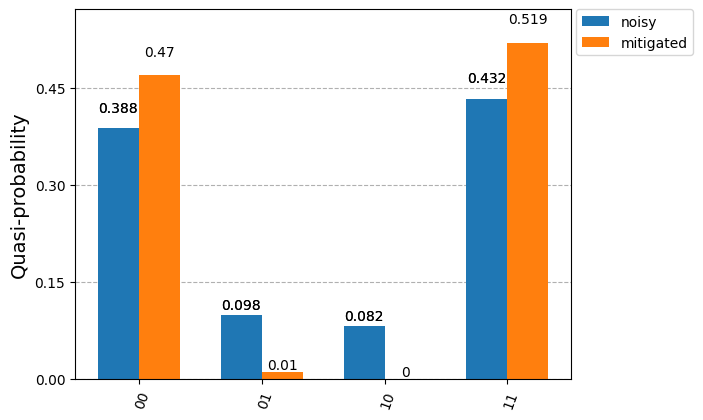

In [33]:
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

### Error Mitigation - Real Device

#### Entangglement Circuit

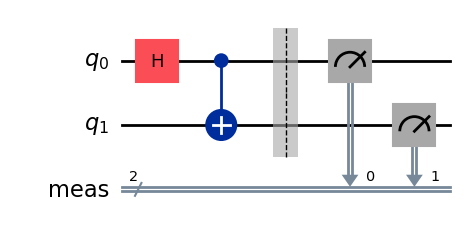

In [34]:
circuit = QuantumCircuit(2)

circuit.h(0)
circuit.cx(0, 1)

circuit.measure_all()

circuit.draw("mpl")

#### Generate Calibration Circuit

In [35]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [36]:
meas_calibs = callibrationCircuitSampler(state_labels)

#### Run calibration Circuit with Noise

In [37]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pass_manager.run(meas_calibs)

In [38]:
# toakes a long time to run so we will retrieve the result later


""" sampler = Sampler(backend)
job = sampler.run(isa_circuit, shots=1000)

while True:
    print(f"Job Status: {job.status()}")
    if job.status() == "DONE" or job.status() == "ERROR":
        break
    time.sleep(10)  # Check status every 10 seconds

cal_result = job.result() """

' sampler = Sampler(backend)\njob = sampler.run(isa_circuit, shots=1000)\n\nwhile True:\n    print(f"Job Status: {job.status()}")\n    if job.status() == "DONE" or job.status() == "ERROR":\n        break\n    time.sleep(10)  # Check status every 10 seconds\n\ncal_result = job.result() '

In [39]:
service = QiskitRuntimeService()

job_id = "cwyzc9s997wg008ybang"

retrieved_job = service.job(job_id)
retrieved_job.status()

'DONE'

In [40]:
job = retrieved_job
cal_result = job.result()

In [41]:
# self_made function for the laest qiskit support to ignis package
cal_result = samplerResultListToAerResult(job, cal_result, state_labels)

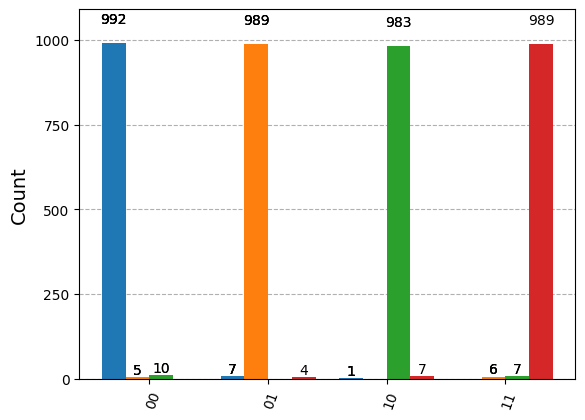

In [42]:
counts = cal_result.get_counts()
plot_histogram(counts)

#### Calibration Matrix with Noise

In [43]:
meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

=> this calibration matrix will be used for the error mitigation

#### Run the circuit with Noise
=> we already run this circuit in the first step

In [44]:
service = QiskitRuntimeService()

job_id = "cwy76tv60bqg008pzdv0"
retrieved_job = service.job(job_id)
retrieved_job.status()

'DONE'

In [45]:
job = retrieved_job
noisy_results = job.result()

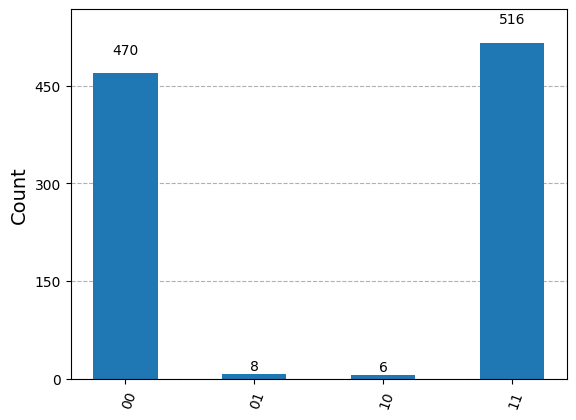

In [46]:
noisy_counts = noisy_results[0].data.meas.get_counts()
plot_histogram(noisy_counts)

In [47]:
# self_made function for the laest qiskit support to ignis package
noisy_results = samplerResultToAerResult(job, noisy_counts)

#### Mitigate the Noise

In [48]:
# get the fitter object
meas_fitter = meas_fitter.filter

# results with mitigation
mitigated_results = meas_fitter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()

#### Comparison

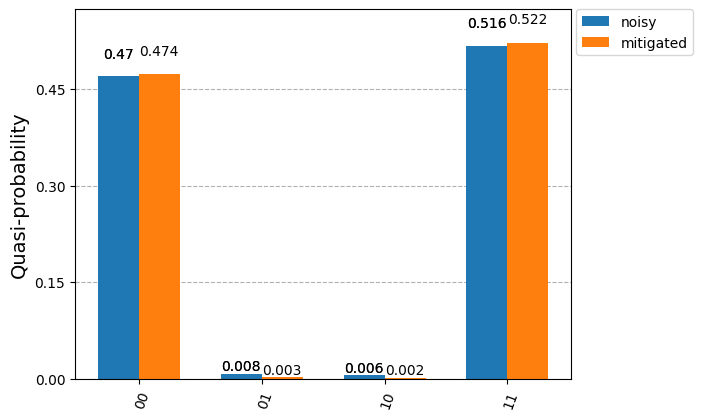

In [49]:
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

=> mitigation is not working with the real devices, due to some syntax changes, if we use the qiskit==0.46, then its possible, but qiskit-ibm-provider is deprecrated as well as backend.run(), we need to modify the calibration function for latest support.\
=> sorry I tried to find out latest syantax and latest function for error mitigation but didn't find, one option i found is available on Estimator, but using this Estimatorv2, we can't get the measurement result.

## Question - 05
Show Heisenberg uncertainty principle in action for X, Y and Z basis measurement.\
Explain your understanding in detail with proper visualization.\
Initialize a state in Y basis and measure in X,Y and Z basis.\
Show how Error Correction works with any of your preferred circuit.

### Heisenberg Uncertainty Principle

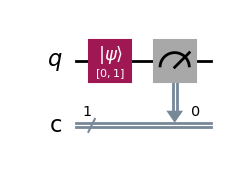

In [50]:
circuit = QuantumCircuit(1, 1)

# Intializing circuit with |1> state in Z basis
circuit.initialize([0, 1], 0)

# measuring the state on z basis
circuit.measure(0, 0)

circuit.draw('mpl')

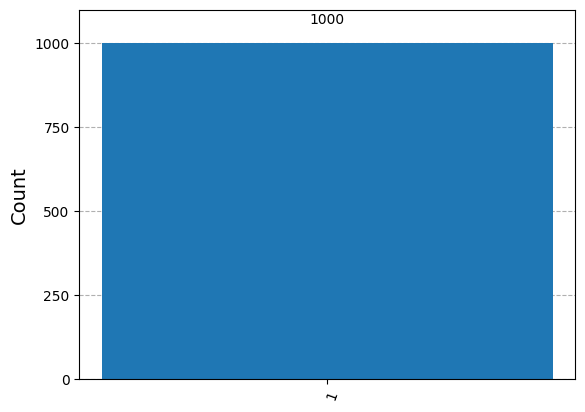

In [51]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> as the circuit is initialized on z basis so measing on z basisi will be certain as we initialized.

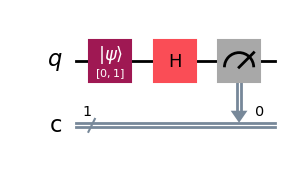

In [52]:
circuit = QuantumCircuit(1, 1)

# Intializing circuit with |1> state in Z basis
circuit.initialize([0, 1], 0)

#measuring the state on x basis
circuit.h(0)
circuit.measure(0, 0)

circuit.draw('mpl')

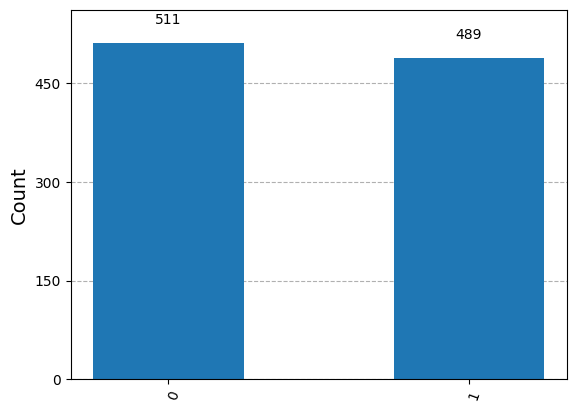

In [53]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> according to Heisenberg Uncertainty Principle, if we initialize in a basis and measure on another basis, outcome will be uncertain.

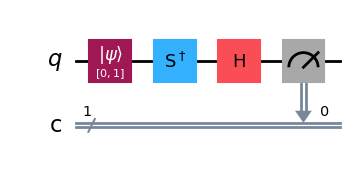

In [54]:
circuit = QuantumCircuit(1, 1)

# Intializing circuit with |1> state in Z basis
circuit.initialize([0, 1], 0)

#measuring the state on y basis
circuit.sdg(0)
circuit.h(0)
circuit.measure(0, 0)

circuit.draw('mpl')

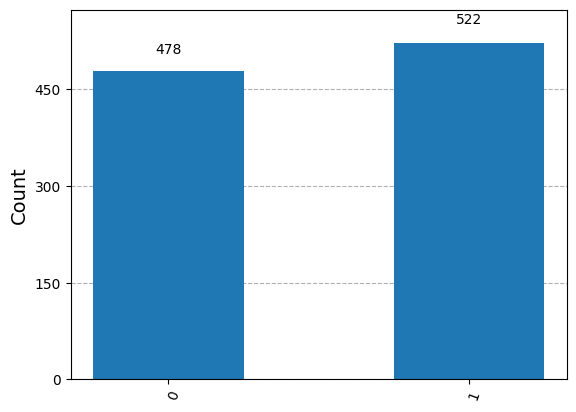

In [55]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> according to Heisenberg Uncertainty Principle, if we initialize in a basis and measure on another basis, outcome will be uncertain.

### Initializing state in y basis

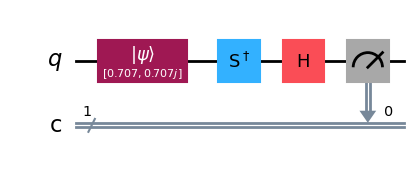

In [56]:
circuit = QuantumCircuit(1, 1)

# initializing circuit in y basis with |+i> state
circuit.initialize([1/sqrt(2), 1j/sqrt(2)], 0)

#measuring the state on y basis
circuit.sdg(0)
circuit.h(0)
circuit.measure(0, 0)

circuit.draw('mpl')

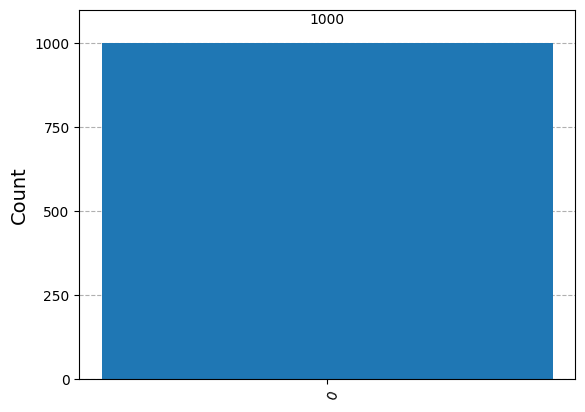

In [57]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> Result is certain, as we measure on the same basis

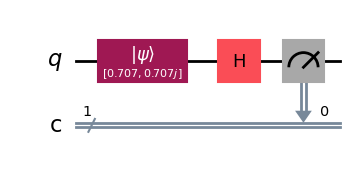

In [58]:
circuit = QuantumCircuit(1, 1)

# initializing circuit in y basis with |+i> state
circuit.initialize([1/sqrt(2), 1j/sqrt(2)], 0)

#measuring the state on x basis
circuit.h(0)
circuit.measure(0, 0)

circuit.draw('mpl')

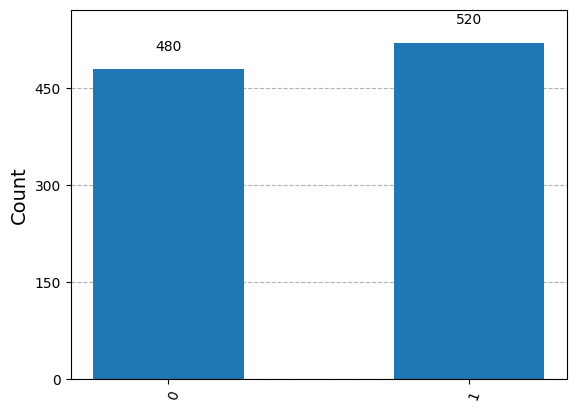

In [59]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> according to Heisenberg Uncertainty Principle, if we initialize in a basis and measure on another basis, outcome will be uncertain.

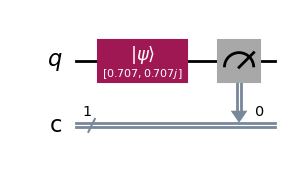

In [60]:
circuit = QuantumCircuit(1, 1)

# initializing circuit in y basis with |+i> state
circuit.initialize([1/sqrt(2), 1j/sqrt(2)], 0)

#measuring the state on z basis
circuit.measure(0, 0)

circuit.draw('mpl')

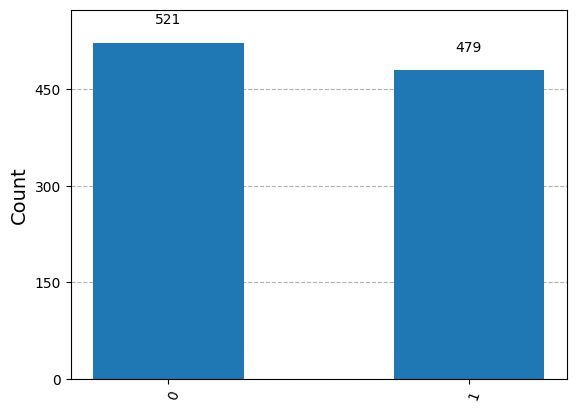

In [61]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> according to Heisenberg Uncertainty Principle, if we initialize in a basis and measure on another basis, outcome will be uncertain.

### Error Correction using a simple circuit

#### Run on Simulator without any error

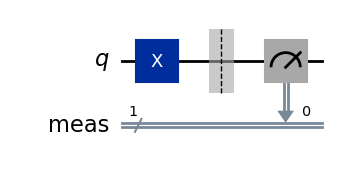

In [62]:
circuit = QuantumCircuit(1)

# initializing circuit in |1> state
circuit.x(0)

circuit.measure_all()

circuit.draw('mpl')

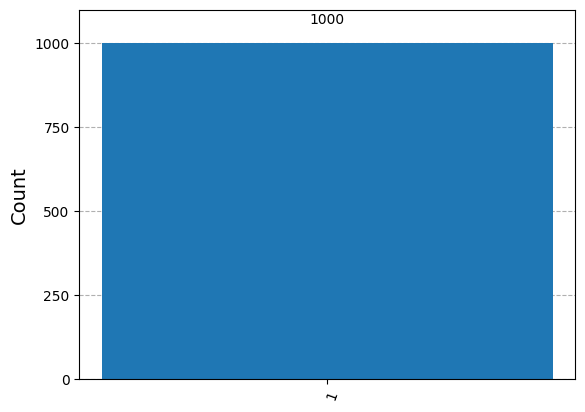

In [63]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)
isa_circuit = pass_manager.run(circuit)
job = simulator.run(isa_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

=> this should be the output for this circuit

#### Run on simulator with error

In [64]:
def constructCircuit():
    circuit = QuantumCircuit(1)

    # initializing circuit in |1> state
    circuit.x(0)

    
    # Apply random bit flip with 10% probability
    if random.random() < 0.1:
        circuit.x(0)
    
    circuit.measure_all()
    
    return circuit

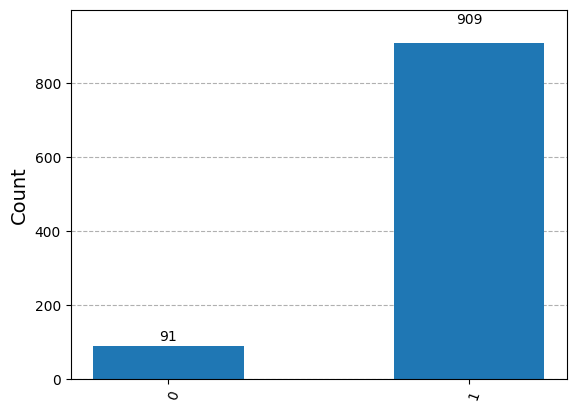

In [65]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)

all_counts_error = Counter()

for i in range(1000):
    circuit = constructCircuit()
    isa_circuit = pass_manager.run(circuit)
    job = simulator.run(isa_circuit, shots=1)
    result = job.result()
    counts = result.get_counts()
    all_counts_error.update(counts)

plot_histogram(all_counts_error)

=> we initialize the circuit with 1 state but we got some 0 state because of random error 10%

#### Run on simulator with error correction using repeatation code

In [66]:
def constructCircuit():
    circuit = QuantumCircuit(5, 1)

    # initializing circuit in |1> state
    circuit.x(0)

    # Encoding
    circuit.cx(0, 1)
    circuit.cx(0, 2)

    # Apply random bit flip with 10% probability
    if random.random() < 0.1:
        circuit.x(random.randint(0, 2))

    # syndrome generate
    circuit.cx(0, 3)
    circuit.cx(1, 3)
    circuit.cx(1, 4)
    circuit.cx(2, 4)

    # Recovery Protocol
    circuit.cx(3, 0)
    circuit.cx(4, 2)
    circuit.ccx(4, 3, 0)
    circuit.ccx(4, 3, 2)
    circuit.ccx(4, 3, 1)

    circuit.measure(0, 0)
    
    return circuit

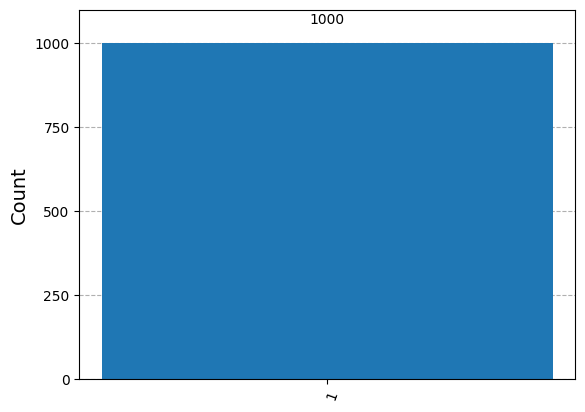

In [67]:
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=simulator)

all_counts_error_corrected = Counter()

for i in range(1000):
    circuit = constructCircuit()
    isa_circuit = pass_manager.run(circuit)
    job = simulator.run(isa_circuit, shots=1)
    result = job.result()
    counts = result.get_counts()
    all_counts_error_corrected.update(counts)

plot_histogram(all_counts_error_corrected)

=> Here you can see all the error are corrected using repeatation code, if we comment out the recovery protocol, this function will generate some noise, and when we use the recovery protocol, it will recover the error

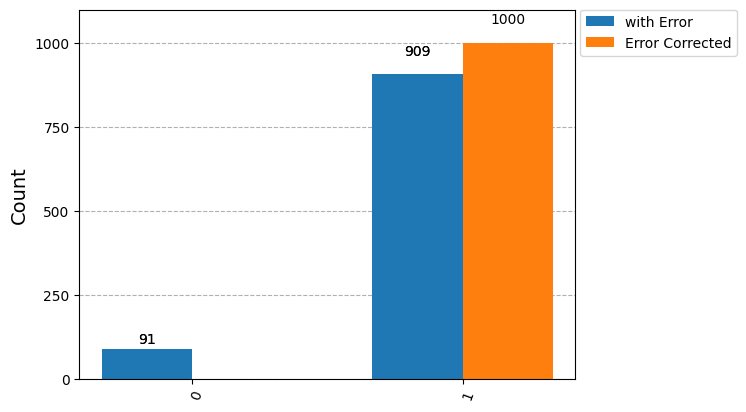

In [68]:
plot_histogram([all_counts_error, all_counts_error_corrected], legend=['with Error', 'Error Corrected'])

=> compare of both result without error correction and with error correction

# <center><font size="50" color="red">Thank You</font></center>